##1. Import library


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

##2. Data preprocessing


In [ ]:
import os
import glob
from PIL import Image
import torchvision.transforms.v2 as transforms
import torchvision.io as tv_io

In [ ]:
train_path = "/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train"
valid_path = "/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test"

In [ ]:
pre_trans = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
data_labels = [
    "freshapples",
    "freshbanana",
    "freshoranges",
    "rottenapples",
    "rottenbanana",
    "rottenoranges",
]

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data_dir):
        self.imgs = []
        self.labels = []

        for idx, label in enumerate(data_labels):
            folder_path = os.path.join(data_dir, label)
            data_paths = glob.glob(os.path.join(folder_path, "*.png"), recursive=True)
            for path in data_paths:
                img = tv_io.read_image(path, tv_io.ImageReadMode.RGB)
                img = img.float() / 255.0
                self.imgs.append(pre_trans(img).to(device))
                self.labels.append(torch.tensor(idx).to(device).float())

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        return img, label

In [ ]:
train_data = MyDataset(train_path)
valid_data = MyDataset(valid_path)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

In [8]:
print(len(train_loader))
print(len(valid_loader))

341
85


In [9]:
n_classes = len(data_labels)
print(n_classes)

6


##3. Build model


In [ ]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

for param in vgg16.parameters():
    param.requires_grad = False

vgg16.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(4096, n_classes),
)

model = vgg16.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 229MB/s]  


In [11]:
model = model.to(device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [13]:
train_N, valid_N = len(train_loader.dataset), len(valid_loader.dataset)

In [ ]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    accuracy = pred.eq(y.view_as(pred)).sum().item()
    return accuracy / N

##4.Train and valid model


In [ ]:
def train():
    loss = 0
    accuracy = 0
    model.train()
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y.long())
        batch_loss.backward()
        optimizer.step()
        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print(f"Loss: {loss:.4f} Accuracy: {accuracy*100:.2f}%")

In [ ]:
def valid():
    loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            batch_loss = loss_function(output, y.long())
            loss += batch_loss.item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print(f"Loss: {loss:.4f} Accuracy: {accuracy*100:.2f}%")

In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}/{num_epochs}")
    train()
    valid()

Epoch: 1/5
Loss: 188.0004 Accuracy: 91.55%
Loss: 11.5503 Accuracy: 97.00%
Epoch: 2/5
Loss: 140.4032 Accuracy: 95.78%
Loss: 9.1454 Accuracy: 98.11%
Epoch: 3/5
Loss: 218.0456 Accuracy: 96.35%
Loss: 50.5468 Accuracy: 97.00%
Epoch: 4/5
Loss: 255.0615 Accuracy: 97.19%
Loss: 11.8689 Accuracy: 98.67%
Epoch: 5/5
Loss: 111.2453 Accuracy: 98.40%
Loss: 8.0882 Accuracy: 99.18%


In [ ]:
from torchvision.io import read_image, ImageReadMode
import torch.nn.functional as F
import matplotlib.pyplot as plt


def predict_sample(image_path):
    img = read_image(image_path, ImageReadMode.RGB).float() / 255.0
    img = pre_trans(img)
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        prob = F.softmax(output, dim=1)
        pred_idx = torch.argmax(prob, dim=1).item()
        pred_label = data_labels[pred_idx]

    plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu())
    plt.title(f"Prediction: {pred_label}")
    plt.axis("off")
    plt.show()

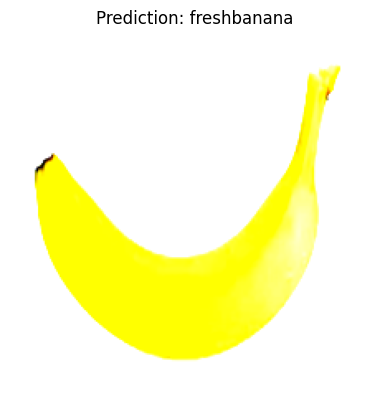

In [ ]:
predict_sample(
    "/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshbanana/Screen Shot 2018-06-12 at 10.00.37 PM.png"
)

In [ ]:
def result():
    loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            batch_loss = loss_function(output, y.long())
            loss += batch_loss.item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print(f"Accuracy: {accuracy*100:.2f}%")

In [22]:
result()

Accuracy: 99.18%


In [ ]:
torch.save(model, "vgg16_fruit_classifier.pth")  # Lưu toàn bộ model